In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the classifier model
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

# Load hidden states
hidden_states = torch.load('hidden_states.ViT.pt')

# Convert hidden states to torch tensor
hidden_states = torch.tensor(hidden_states.squeeze(0), dtype=torch.float32)  # Reshape to (253, 1024)

# Example target labels for training (replace with actual labels)
# Assuming there are 10 classes and hidden states shape is (seq_length, feature_dim)
seq_length, feature_dim = hidden_states.shape
num_classes = 10  # Adjust based on your classification task
targets = torch.randint(0, num_classes, (seq_length,))

# Define the classifier
classifier = SimpleClassifier(input_dim=feature_dim, num_classes=num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Training the classifier
epochs = 10
classifier.train()
for epoch in range(epochs):
    epoch_loss = 0
    for i in tqdm(range(seq_length), desc=f"Epoch {epoch + 1}/{epochs}"):
        optimizer.zero_grad()
        
        # Select the hidden state for the current sample
        input_data = hidden_states[i].unsqueeze(0)  # Add batch dimension
        target = targets[i].unsqueeze(0)
        
        # Forward pass
        output = classifier(input_data)
        
        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    logging.info(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / seq_length}")

# Save the trained classifier model
torch.save(classifier.state_dict(), 'simple_classifier_model.pth')
logging.info("Simple classifier model saved to simple_classifier_model.pth")

# Evaluating the model on the entire dataset
classifier.eval()
predicted_classes = []
with torch.no_grad():
    for i in tqdm(range(seq_length), desc="Evaluating"):
        input_data = hidden_states[i].unsqueeze(0)  # Add batch dimension
        logits = classifier(input_data)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        predicted_classes.append(predicted_class.item())

predicted_classes = np.array(predicted_classes)

# Save the predicted classes for the entire period
np.save('predicted_classes_per_hour.npy', predicted_classes)
logging.info("Predicted classes saved to predicted_classes_per_hour.npy")

print("Predicted Classes for Each Hour During the Entire Period:\n", predicted_classes)


/tmp/ipykernel_92412/3683660257.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hidden_states = torch.tensor(hidden_states.squeeze(0), dtype=torch.float32)  # Reshape to (253, 1024)
Epoch 1/10: 100%|██████████| 253/253 [00:00<00:00, 938.04it/s]
2024-06-29 11:13:20,478 - INFO - Epoch 1/10, Loss: 2.344398675228767
Epoch 2/10: 100%|██████████| 253/253 [00:00<00:00, 1210.65it/s]
2024-06-29 11:13:20,689 - INFO - Epoch 2/10, Loss: 2.333923959920529
Epoch 3/10: 100%|██████████| 253/253 [00:00<00:00, 1212.64it/s]
2024-06-29 11:13:20,899 - INFO - Epoch 3/10, Loss: 2.3251124823046294
Epoch 4/10: 100%|██████████| 253/253 [00:00<00:00, 1027.04it/s]
2024-06-29 11:13:21,147 - INFO - Epoch 4/10, Loss: 2.316880171006847
Epoch 5/10: 100%|██████████| 253/253 [00:00<00:00, 1143.63it/s]
2024-06-29 11:13:21,369 - INFO - Epoch 5/10, Loss: 2.309445196460

Predicted Classes for Each Hour During the Entire Period:
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 8 8 8 4 8 8 8 8 8 8 8 6 6 6 6 6 6 6 6
 6 6 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 8 8 8 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4
 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


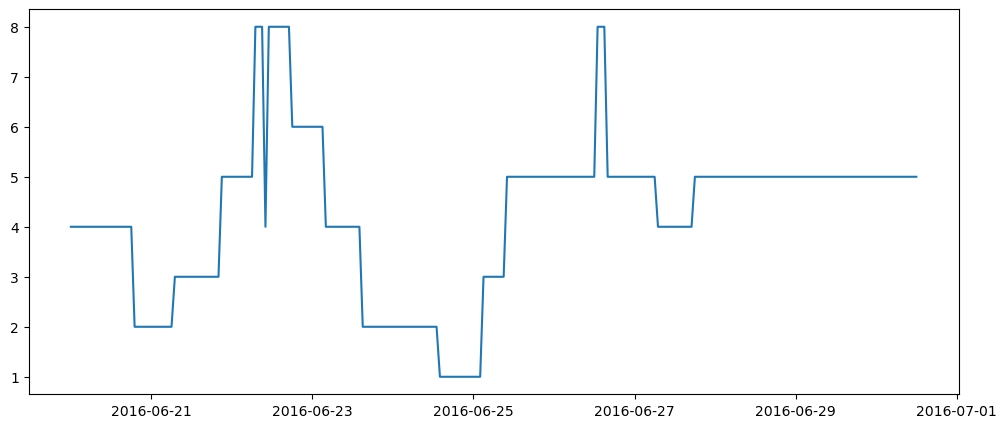

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

time=pd.date_range('2016-06-20 00:00', '2016-06-30 12:00', freq='h')
fig, ax = plt.subplots(1,1,figsize=(12, 5))

ax.plot(time, predicted_classes)

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from tqdm import tqdm
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the classifier model
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

# Load hidden states
hidden_states = torch.load('hidden_states.ViT.pt')

# Convert hidden states to torch tensor
hidden_states = torch.tensor(hidden_states.squeeze(0), dtype=torch.float32)  # Reshape to (253, 1024)

# Example target labels for training (replace with actual labels)
# Hidden states shape is (seq_length, feature_dim)
seq_length, feature_dim = hidden_states.shape
# Generate dummy targets for demonstration; replace with actual targets
dummy_targets = np.random.randint(0, 10, seq_length)  # Assuming 10 possible classes initially

# Cross-validation and grid search for the number of classes
kf = KFold(n_splits=5)
num_classes_list = [2, 3, 5, 10, 15]  # List of different number of classes to evaluate

best_num_classes = None
best_accuracy = 0

for num_classes in num_classes_list:
    logging.info(f"Evaluating number of classes: {num_classes}")
    
    fold_accuracies = []
    
    for train_index, val_index in kf.split(hidden_states):
        # Split the data into training and validation sets
        X_train, X_val = hidden_states[train_index], hidden_states[val_index]
        y_train = torch.randint(0, num_classes, (len(train_index),))  # Replace with actual targets for training
        y_val = torch.randint(0, num_classes, (len(val_index),))  # Replace with actual targets for validation

        # Define the classifier
        classifier = SimpleClassifier(input_dim=feature_dim, num_classes=num_classes)
        
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(classifier.parameters(), lr=0.001)
        
        # Training the classifier
        epochs = 5  # Use fewer epochs for cross-validation
        classifier.train()
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(len(train_index)):
                optimizer.zero_grad()
                
                # Select the hidden state for the current sample
                input_data = X_train[i].unsqueeze(0)  # Add batch dimension
                target = y_train[i].unsqueeze(0)
                
                # Forward pass
                output = classifier(input_data)
                
                # Compute loss
                loss = criterion(output, target)
                epoch_loss += loss.item()
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
        
        # Evaluate on validation set
        classifier.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for i in range(len(val_index)):
                input_data = X_val[i].unsqueeze(0)  # Add batch dimension
                target = y_val[i]
                
                logits = classifier(input_data)
                predicted_class = torch.argmax(logits, dim=1)
                
                total += 1
                if predicted_class.item() == target.item():
                    correct += 1
        
        accuracy = correct / total
        fold_accuracies.append(accuracy)
    
    avg_accuracy = np.mean(fold_accuracies)
    logging.info(f"Average accuracy for {num_classes} classes: {avg_accuracy}")
    
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_num_classes = num_classes

logging.info(f"Best number of classes: {best_num_classes} with accuracy: {best_accuracy}")

# Use the optimal number of classes for final training and evaluation
num_classes = best_num_classes

# Define the classifier
classifier = SimpleClassifier(input_dim=feature_dim, num_classes=num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Training the classifier on the entire dataset
epochs = 10
classifier.train()
for epoch in range(epochs):
    epoch_loss = 0
    for i in tqdm(range(seq_length), desc=f"Epoch {epoch + 1}/{epochs}"):
        optimizer.zero_grad()
        
        # Select the hidden state for the current sample
        input_data = hidden_states[i].unsqueeze(0)  # Add batch dimension
        target = torch.randint(0, num_classes, (1,))  # Replace with actual target
        
        # Forward pass
        output = classifier(input_data)
        
        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    logging.info(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / seq_length}")

# Save the trained classifier model
torch.save(classifier.state_dict(), 'final_simple_classifier_model.pth')
logging.info("Final simple classifier model saved to final_simple_classifier_model.pth")

# Evaluating the model on the entire dataset
classifier.eval()
predicted_classes = []
with torch.no_grad():
    for i in tqdm(range(seq_length), desc="Evaluating"):
        input_data = hidden_states[i].unsqueeze(0)  # Add batch dimension
        logits = classifier(input_data)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        predicted_classes.append(predicted_class.item())

predicted_classes = np.array(predicted_classes)

# Save the predicted classes for the entire period
np.save('predicted_classes_per_hour.npy', predicted_classes)
logging.info("Predicted classes saved to predicted_classes_per_hour.npy")

print("Predicted Classes for Each Hour During the Entire Period:\n", predicted_classes)


/tmp/ipykernel_92412/2726571208.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hidden_states = torch.tensor(hidden_states.squeeze(0), dtype=torch.float32)  # Reshape to (253, 1024)
2024-06-29 11:20:21,303 - INFO - Evaluating number of classes: 2


2024-06-29 11:20:50,275 - INFO - Average accuracy for 2 classes: 0.4991423670668954
2024-06-29 11:20:50,275 - INFO - Evaluating number of classes: 3
2024-06-29 11:22:18,971 - INFO - Average accuracy for 3 classes: 0.3417960948330553
2024-06-29 11:22:18,973 - INFO - Evaluating number of classes: 5
2024-06-29 11:23:46,794 - INFO - Average accuracy for 5 classes: 0.19815256467492187
2024-06-29 11:23:46,844 - INFO - Evaluating number of classes: 10
2024-06-29 11:25:23,295 - INFO - Average accuracy for 10 classes: 0.10695798773467421
2024-06-29 11:25:23,343 - INFO - Evaluating number of classes: 15
2024-06-29 11:27:49,496 - INFO - Average accuracy for 15 classes: 0.06684896261660282
2024-06-29 11:27:49,543 - INFO - Best number of classes: 2 with accuracy: 0.4991423670668954
Epoch 1/10: 100%|██████████| 2917/2917 [00:01<00:00, 1933.07it/s]
2024-06-29 11:27:51,055 - INFO - Epoch 1/10, Loss: 0.7053316811053034
Epoch 2/10: 100%|██████████| 2917/2917 [00:01<00:00, 2001.09it/s]
2024-06-29 11:27:5

Predicted Classes for Each Hour During the Entire Period:
 [0 0 0 ... 0 0 0]


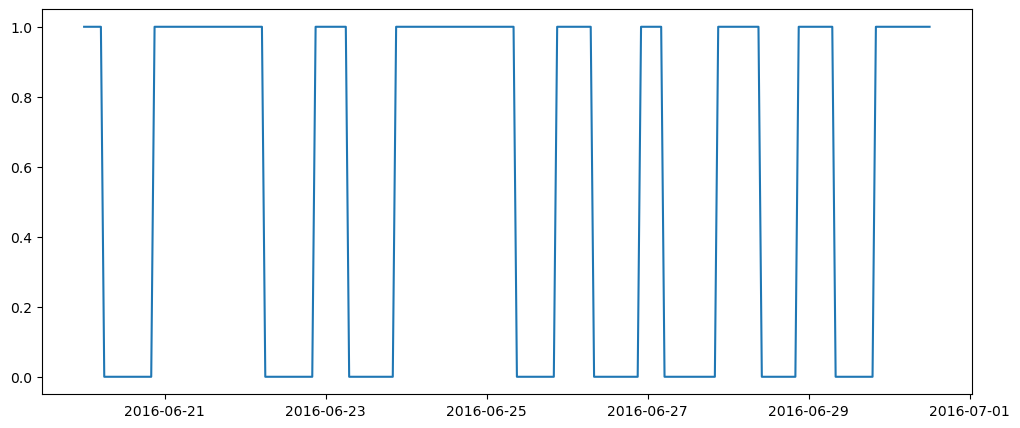

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

time=pd.date_range('2016-06-20 00:00', '2016-09-30 12:00', freq='h')
fig, ax = plt.subplots(1,1,figsize=(12, 5))

ax.plot(time, predicted_classes)

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from tqdm import tqdm
import logging
from multiprocessing import Pool, cpu_count

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the classifier model
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

# Load hidden states
hidden_states = torch.load('hidden_states.ViT.pt')

# Convert hidden states to torch tensor
hidden_states = torch.tensor(hidden_states.squeeze(0), dtype=torch.float32)  # Reshape to (253, 1024)

# Example target labels for training (replace with actual labels)
# Hidden states shape is (seq_length, feature_dim)
seq_length, feature_dim = hidden_states.shape
# Generate dummy targets for demonstration; replace with actual targets
dummy_targets = np.random.randint(0, 10, seq_length)  # Assuming 10 possible classes initially

# Cross-validation and grid search for the number of classes
kf = KFold(n_splits=5)
num_classes_list = [2, 3, 5, 10, 15]  # List of different number of classes to evaluate

best_num_classes = None
best_accuracy = 0

def evaluate_num_classes(num_classes):
    fold_accuracies = []
    
    for train_index, val_index in kf.split(hidden_states):
        # Split the data into training and validation sets
        X_train, X_val = hidden_states[train_index], hidden_states[val_index]
        y_train = torch.randint(0, num_classes, (len(train_index),))  # Replace with actual targets for training
        y_val = torch.randint(0, num_classes, (len(val_index),))  # Replace with actual targets for validation

        # Define the classifier
        classifier = SimpleClassifier(input_dim=feature_dim, num_classes=num_classes)
        
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(classifier.parameters(), lr=0.001)
        
        # Training the classifier
        epochs = 5  # Use fewer epochs for cross-validation
        classifier.train()
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(len(train_index)):
                optimizer.zero_grad()
                
                # Select the hidden state for the current sample
                input_data = X_train[i].unsqueeze(0)  # Add batch dimension
                target = y_train[i].unsqueeze(0)
                
                # Forward pass
                output = classifier(input_data)
                
                # Compute loss
                loss = criterion(output, target)
                epoch_loss += loss.item()
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
        
        # Evaluate on validation set
        classifier.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for i in range(len(val_index)):
                input_data = X_val[i].unsqueeze(0)  # Add batch dimension
                target = y_val[i]
                
                logits = classifier(input_data)
                predicted_class = torch.argmax(logits, dim=1)
                
                total += 1
                if predicted_class.item() == target.item():
                    correct += 1
        
        accuracy = correct / total
        fold_accuracies.append(accuracy)
    
    avg_accuracy = np.mean(fold_accuracies)
    return num_classes, avg_accuracy

# Use multiprocessing to evaluate different numbers of classes in parallel
with Pool(cpu_count()) as pool:
    results = pool.map(evaluate_num_classes, num_classes_list)

for num_classes, avg_accuracy in results:
    logging.info(f"Average accuracy for {num_classes} classes: {avg_accuracy}")
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_num_classes = num_classes

logging.info(f"Best number of classes: {best_num_classes} with accuracy: {best_accuracy}")

# Use the optimal number of classes for final training and evaluation
num_classes = best_num_classes

# Define the classifier
classifier = SimpleClassifier(input_dim=feature_dim, num_classes=num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Training the classifier on the entire dataset
epochs = 10
classifier.train()
for epoch in range(epochs):
    epoch_loss = 0
    for i in tqdm(range(seq_length), desc=f"Epoch {epoch + 1}/{epochs}"):
        optimizer.zero_grad()
        
        # Select the hidden state for the current sample
        input_data = hidden_states[i].unsqueeze(0)  # Add batch dimension
        target = torch.randint(0, num_classes, (1,))  # Replace with actual target
        
        # Forward pass
        output = classifier(input_data)
        
        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    logging.info(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / seq_length}")

# Save the trained classifier model
torch.save(classifier.state_dict(), 'final_simple_classifier_model.pth')
logging.info("Final simple classifier model saved to final_simple_classifier_model.pth")

# Evaluating the model on the entire dataset
classifier.eval()
predicted_classes = []
with torch.no_grad():
    for i in tqdm(range(seq_length), desc="Evaluating"):
        input_data = hidden_states[i].unsqueeze(0)  # Add batch dimension
        logits = classifier(input_data)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        predicted_classes.append(predicted_class.item())

predicted_classes = np.array(predicted_classes)

# Save the predicted classes for the entire period
np.save('predicted_classes_per_hour.npy', predicted_classes)
logging.info("Predicted classes saved to predicted_classes_per_hour.npy")

print("Predicted Classes for Each Hour During the Entire Period:\n", predicted_classes)


/tmp/ipykernel_92412/1801776577.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hidden_states = torch.tensor(hidden_states.squeeze(0), dtype=torch.float32)  # Reshape to (253, 1024)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

class CustomLoss(nn.Module):
    def __init__(self, base_loss):
        super(CustomLoss, self).__init__()
        self.base_loss = base_loss

    def forward(self, outputs, targets):
        loss = self.base_loss(outputs, targets)
        smoothness_penalty = torch.mean(torch.abs(outputs[:, 1:] - outputs[:, :-1]))
        loss += 0.01 * smoothness_penalty  # Adjust the penalty weight as needed
        return loss

# Load hidden states
hidden_states = torch.load('hidden_states.ViT.pt')
print(hidden_states.shape)

# Convert hidden states to torch tensor
hidden_states = torch.tensor(hidden_states.squeeze(0), dtype=torch.float32)  # Reshape to (253, 1024)

# Example target labels for training (replace with actual labels)
seq_length, feature_dim = hidden_states.shape
num_classes = 8  # Adjust based on your classification task
targets = torch.randint(0, num_classes, (seq_length,))

# Define the classifier
classifier = SimpleClassifier(input_dim=feature_dim, num_classes=num_classes)

# Loss and optimizer
base_loss = nn.CrossEntropyLoss()
criterion = CustomLoss(base_loss)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Training the classifier
epochs = 10
classifier.train()
for epoch in range(epochs):
    epoch_loss = 0
    for i in tqdm(range(seq_length), desc=f"Epoch {epoch + 1}/{epochs}"):
        optimizer.zero_grad()
        
        # Select the hidden state for the current sample
        input_data = hidden_states[i].unsqueeze(0)  # Add batch dimension
        target = targets[i].unsqueeze(0)
        
        # Forward pass
        output = classifier(input_data)
        
        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    logging.info(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / seq_length}")

# Save the trained classifier model
torch.save(classifier.state_dict(), 'simple_classifier_model.pth')
logging.info("Simple classifier model saved to simple_classifier_model.pth")

# Evaluating the model on the entire dataset
classifier.eval()
predicted_classes = []
with torch.no_grad():
    for i in tqdm(range(seq_length), desc="Evaluating"):
        input_data = hidden_states[i].unsqueeze(0)  # Add batch dimension
        logits = classifier(input_data)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        predicted_classes.append(predicted_class.item())

predicted_classes = np.array(predicted_classes)

# Save the predicted classes for the entire period
np.save('predicted_classes_per_hour.npy', predicted_classes)
logging.info("Predicted classes saved to predicted_classes_per_hour.npy")

print("Predicted Classes for Each Hour During the Entire Period:\n", predicted_classes)


torch.Size([1, 2917, 1024])


/tmp/ipykernel_1178504/1470811637.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hidden_states = torch.tensor(hidden_states.squeeze(0), dtype=torch.float32)  # Reshape to (253, 1024)
Epoch 1/10: 100%|██████████| 2917/2917 [00:09<00:00, 302.40it/s]
2024-06-29 15:29:31,343 - INFO - Epoch 1/10, Loss: 2.1155949633212217
Epoch 2/10: 100%|██████████| 2917/2917 [00:08<00:00, 331.05it/s]
2024-06-29 15:29:40,156 - INFO - Epoch 2/10, Loss: 2.1104598152012217
Epoch 3/10: 100%|██████████| 2917/2917 [00:09<00:00, 313.70it/s]
2024-06-29 15:29:49,456 - INFO - Epoch 3/10, Loss: 2.107746268937062
Epoch 4/10: 100%|██████████| 2917/2917 [00:09<00:00, 307.25it/s]
2024-06-29 15:29:58,952 - INFO - Epoch 4/10, Loss: 2.105588697226521
Epoch 5/10: 100%|██████████| 2917/2917 [00:08<00:00, 364.51it/s]
2024-06-29 15:30:06,957 - INFO - Epoch 5/10, Loss: 2.103

Predicted Classes for Each Hour During the Entire Period:
 [1 7 7 ... 7 7 7]


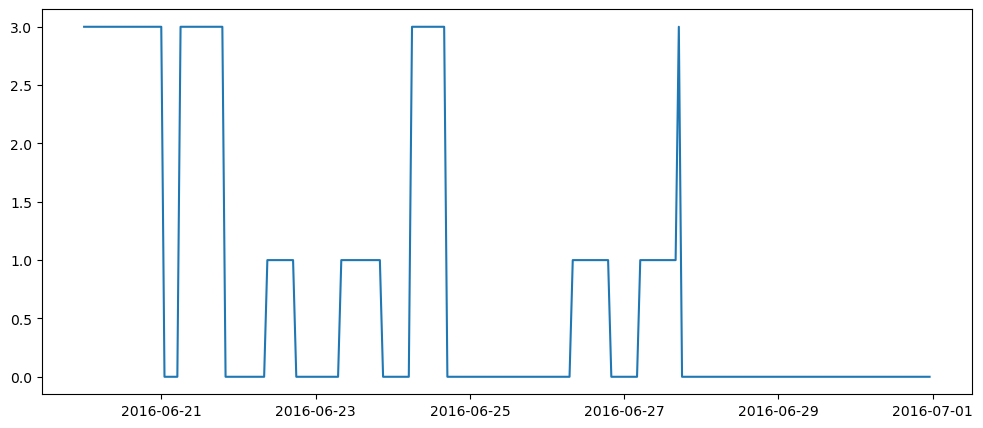

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

time=pd.date_range('2016-06-01 00:00', '2016-09-30 12:00', freq='h')
da = xr.DataArray(predicted_classes, dims=['time',], coords=[time])
xda = da.sel(time=slice('2016-06-20', '2016-06-30'))
fig, ax = plt.subplots(1,1,figsize=(12, 5))

ax.plot(xda.time, xda)
# predicted_classes